In [ ]:
%pip uninstall -y -q openvino openvino-dev openvino-nightly
%pip install -q openvino-nightly opencv-python matplotlib gradio torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

repo_dir = Path("EfficientSAM")

if not repo_dir.exists():
    !git clone https://github.com/yformer/EfficientSAM.git
%cd $repo_dir

/home/ea/work/openvino_notebooks/notebooks/274-efficient-sam/EfficientSAM


In [3]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
import zipfile

MODELS_LIST = {"efficient-sam-vitt": build_efficient_sam_vitt, "efficient-sam-vits": build_efficient_sam_vits}

try:
    from squeeze_sam.build_squeeze_sam import build_squeeze_sam
except ImportError:
    MODELS_LIST["squeeze-sam"] = build_squeeze_sam

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")

In [4]:
import ipywidgets as widgets

model_ids = list(MODELS_LIST)

model_id = widgets.Dropdown(
    options=model_ids,
    value=model_ids[0],
    description="Model:",
    disabled=False,
)

model_id

Dropdown(description='Model:', options=('efficient-sam-vitt', 'efficient-sam-vits'), value='efficient-sam-vitt…

In [5]:
pt_model = MODELS_LIST[model_id.value]()

pt_model.eval();

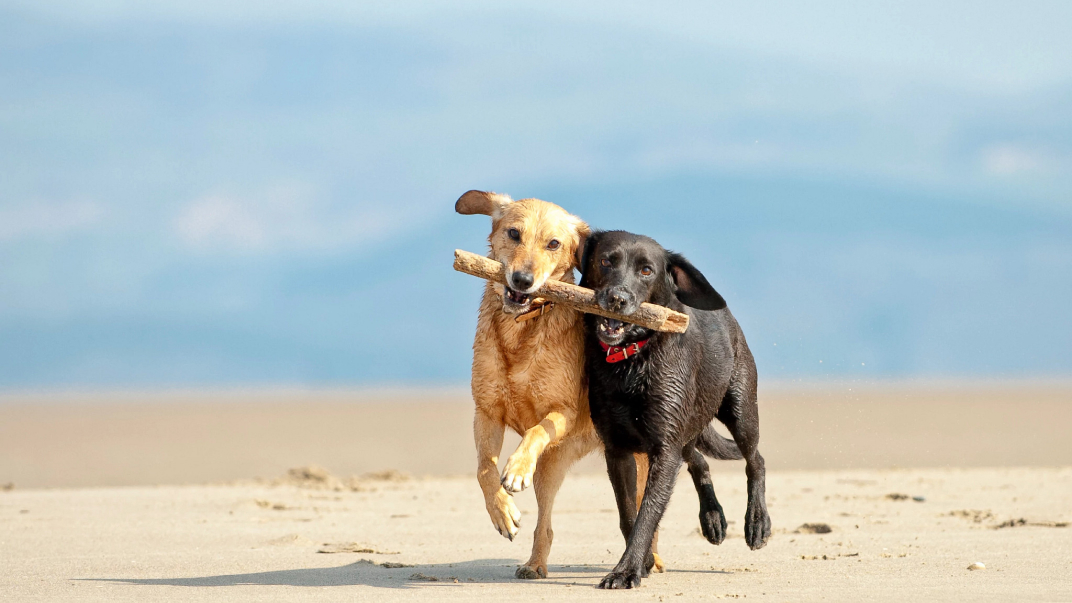

In [6]:
from PIL import Image

image_path = "figs/examples/dogs.jpg"

image = Image.open(image_path)
image

In [7]:
import torch
from torchvision.transforms import ToTensor

def prepare_input(input_image, points, labels):
    img_tensor = ToTensor()(input_image)[None, ...]
    pts_sampled = torch.reshape(torch.tensor(points), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(labels), [1, 1, -1])
    return img_tensor, pts_sampled, pts_labels


def postprocess_results(predicted_iou, predicted_logits):
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

In [8]:
input_points = [[580, 350], [650, 350]]
input_labels = [1, 1]

example_input = prepare_input(Image.open(image_path), input_points, input_labels)

predicted_logits, predicted_iou = pt_model(*example_input)

predicted_mask = postprocess_results(predicted_iou, predicted_logits)

In [9]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )


def show_anns(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    # for ann in mask:
    #     m = ann
    color_mask = np.concatenate([np.random.random(3), [0.5]])
    img[mask] = color_mask
    ax.imshow(img)

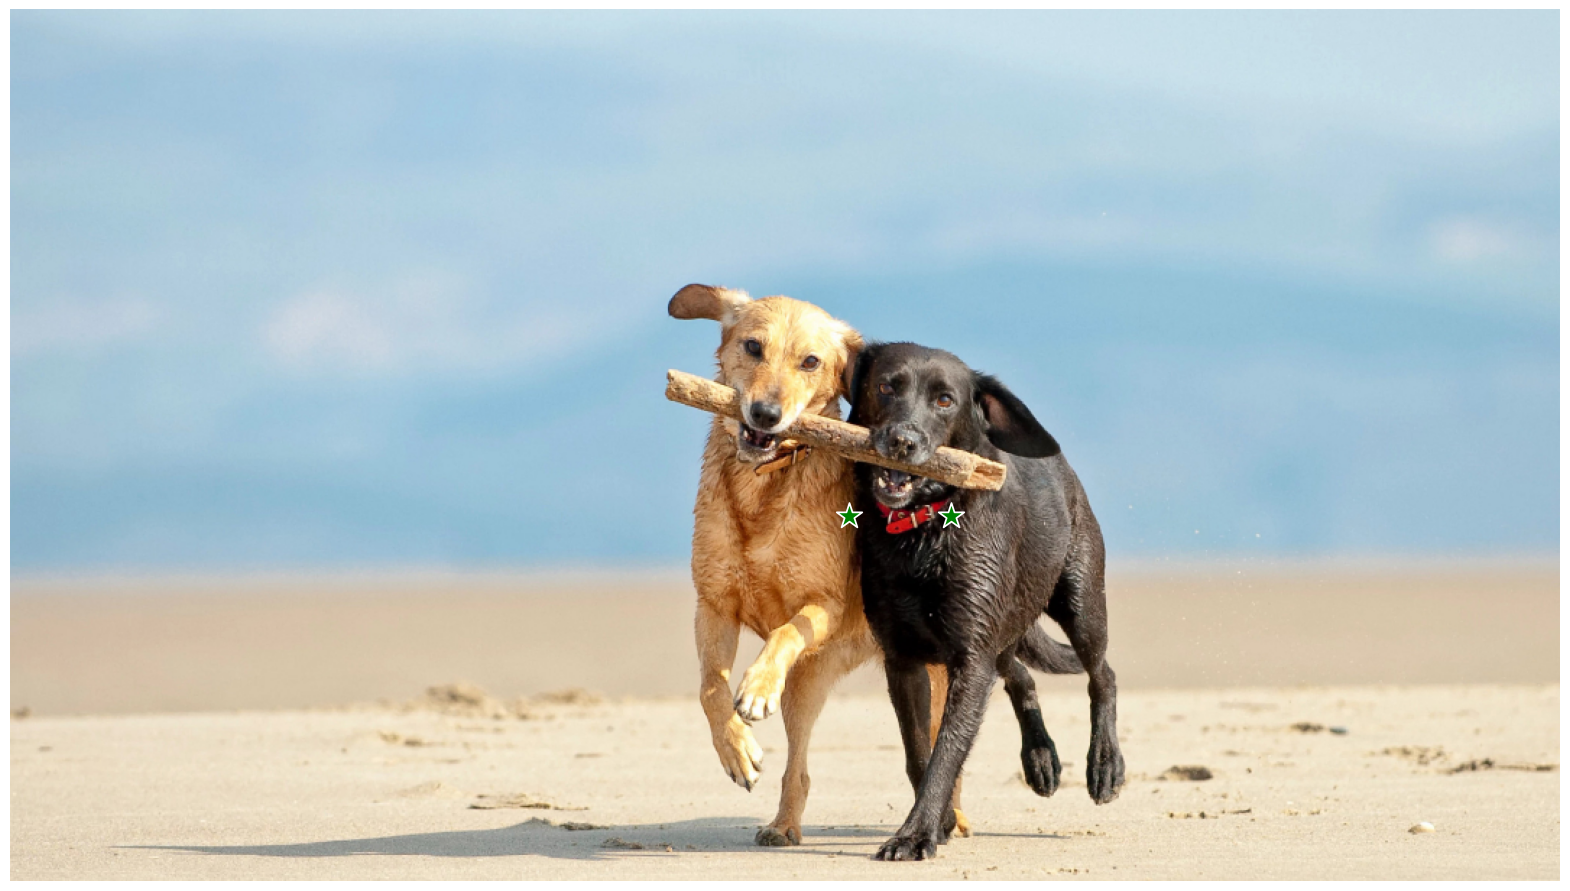

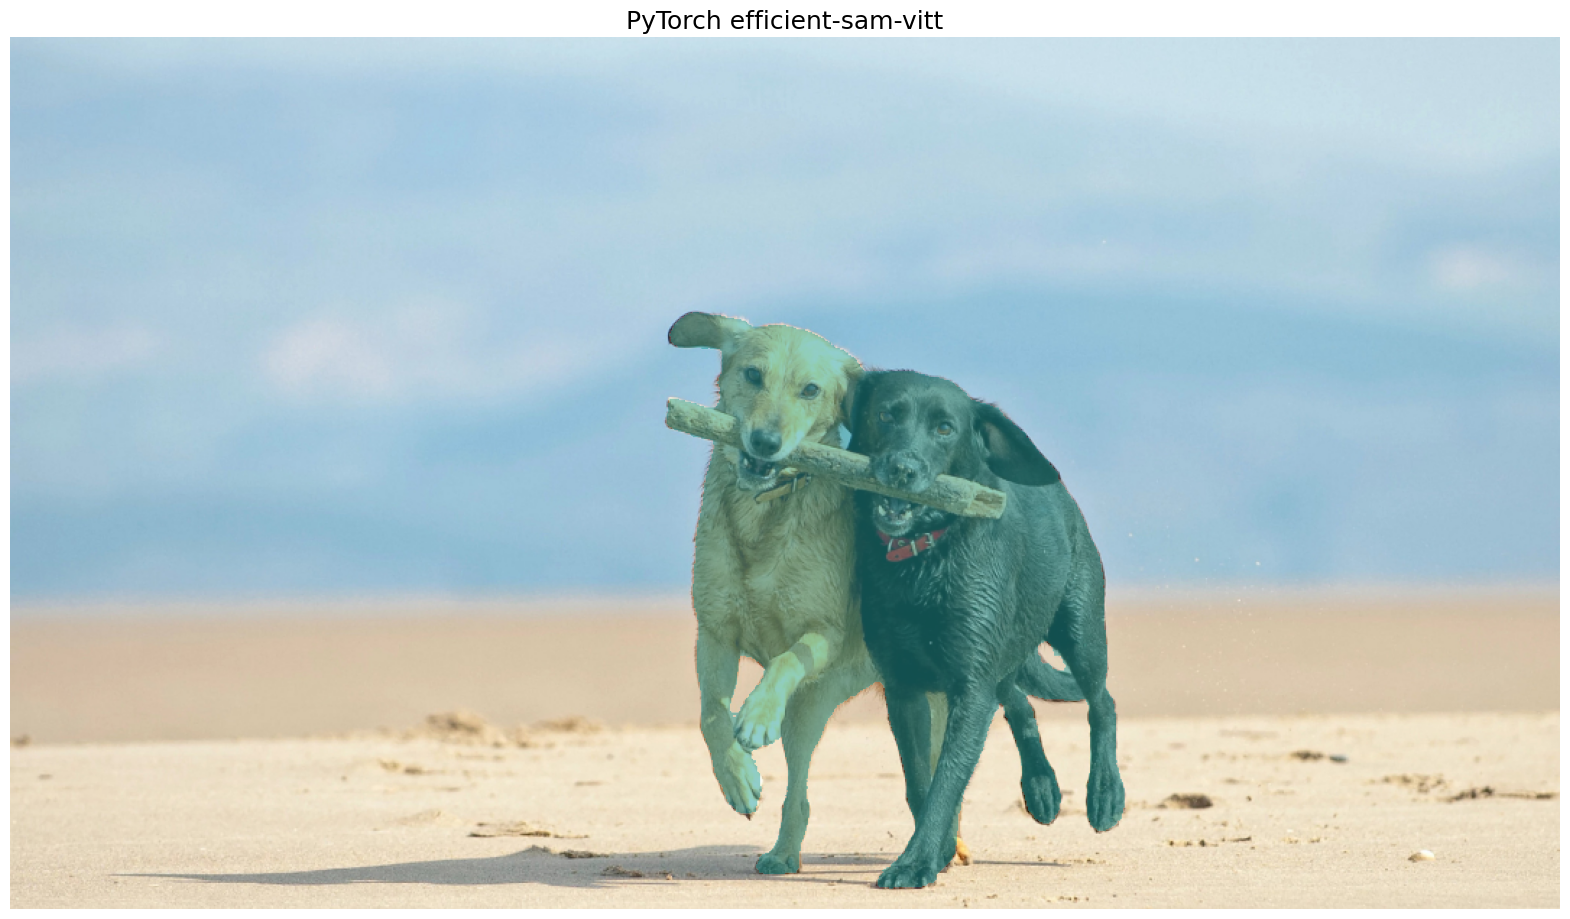

In [10]:
import matplotlib.pyplot as plt
import numpy as np

image = Image.open(image_path)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_points(np.array(input_points), np.array(input_labels), plt.gca())
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_anns(predicted_mask, plt.gca())
plt.title(f"PyTorch {model_id.value}", fontsize=18)
plt.show()

In [11]:
import openvino as ov

core = ov.Core()

ov_model_path = Path(f'{model_id.value}.xml')

if not ov_model_path.exists():
    ov_model = ov.convert_model(pt_model, example_input=example_input)
    ov.save_model(ov_model, ov_model_path)
else:
    ov_model = core.read_model(ov_model_path)

In [12]:
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GNA', 'AUTO'), value='AUTO')

In [13]:
compiled_model = core.compile_model(ov_model, device.value)

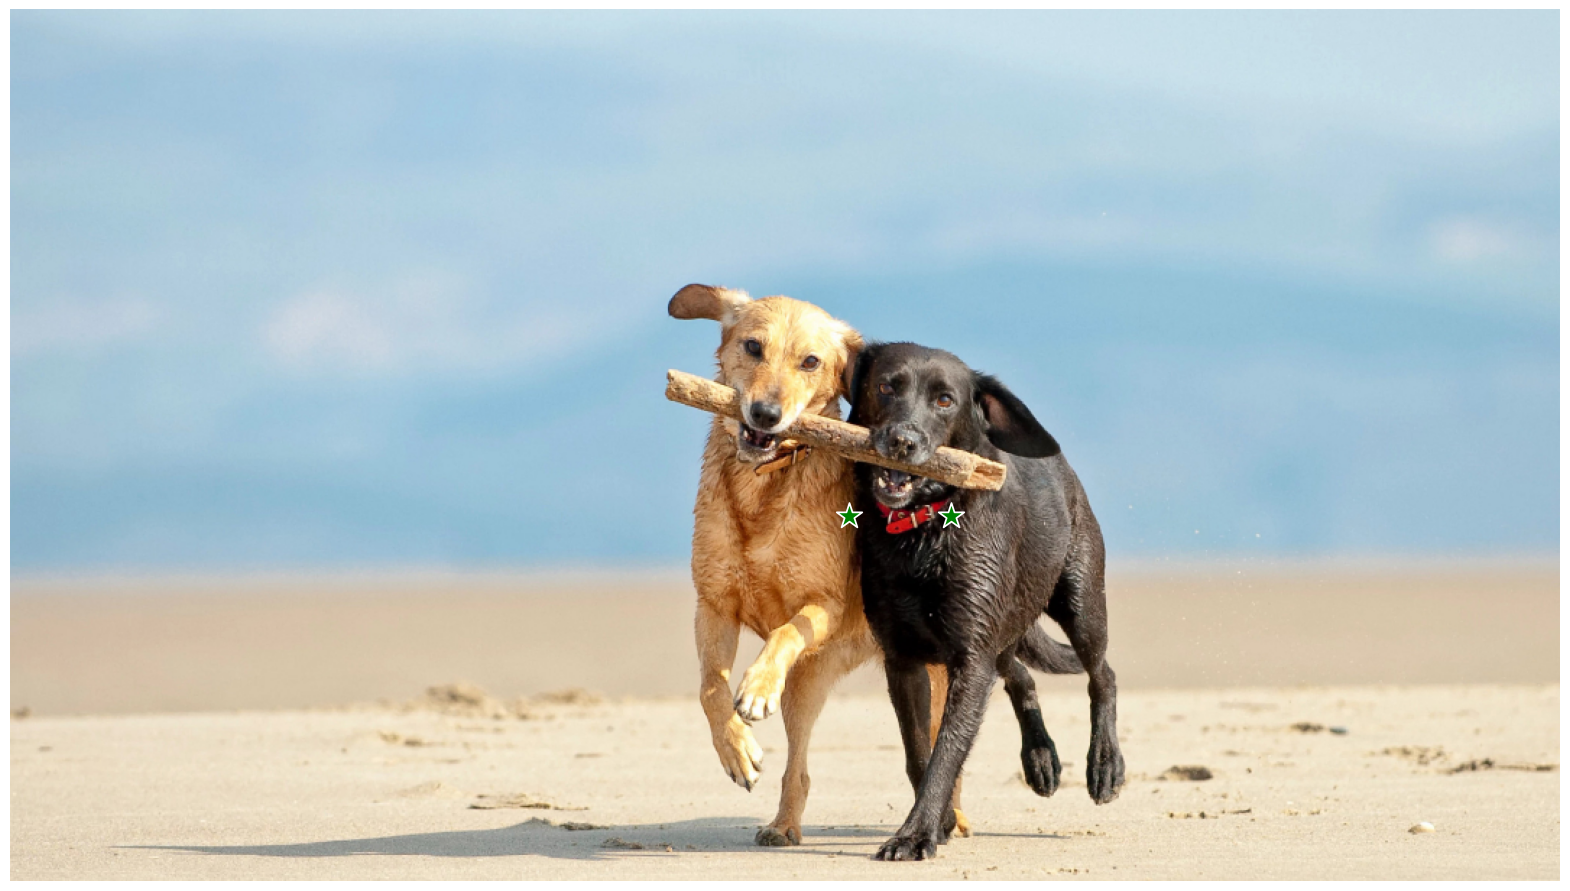

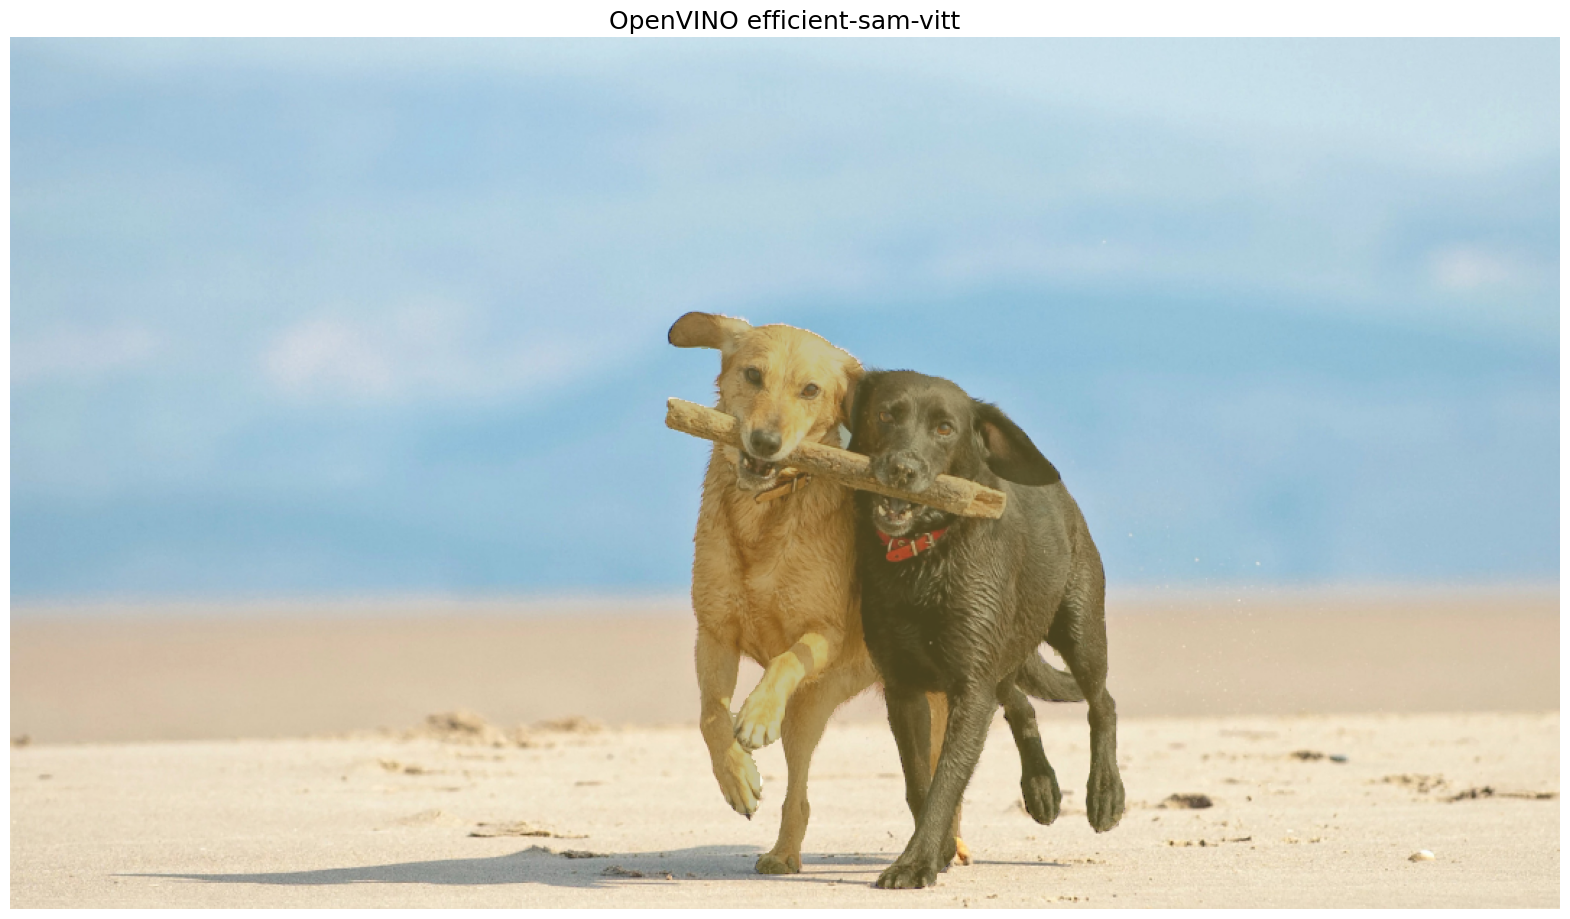

In [14]:
result = compiled_model(example_input)

predicted_logits, predicted_iou = torch.from_numpy(result[0]), torch.from_numpy(result[1])

predicted_mask = postprocess_results(predicted_iou, predicted_logits)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_points(np.array(input_points), np.array(input_labels), plt.gca())
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_anns(predicted_mask, plt.gca())
plt.title(f"OpenVINO {model_id.value}", fontsize=18)
plt.show()

In [23]:
import copy
import gradio as gr
import numpy as np
import torch
from PIL import ImageDraw
from torchvision.transforms import ToTensor


import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def format_results(masks, scores, logits, filter=0):
    annotations = []
    n = len(scores)
    for i in range(n):
        annotation = {}

        mask = masks[i]
        tmp = np.where(mask != 0)
        if np.sum(mask) < filter:
            continue
        annotation["id"] = i
        annotation["segmentation"] = mask
        annotation["bbox"] = [
            np.min(tmp[0]),
            np.min(tmp[1]),
            np.max(tmp[1]),
            np.max(tmp[0]),
        ]
        annotation["score"] = scores[i]
        annotation["area"] = annotation["segmentation"].sum()
        annotations.append(annotation)
    return annotations

def point_prompt(masks, points, point_label, target_height, target_width):  # numpy
    h = masks[0]["segmentation"].shape[0]
    w = masks[0]["segmentation"].shape[1]
    if h != target_height or w != target_width:
        points = [
            [int(point[0] * w / target_width), int(point[1] * h / target_height)]
            for point in points
        ]
    onemask = np.zeros((h, w))
    for i, annotation in enumerate(masks):
        if type(annotation) == dict:
            mask = annotation["segmentation"]
        else:
            mask = annotation
        for i, point in enumerate(points):
            if point[1] < mask.shape[0] and point[0] < mask.shape[1]:
                if mask[point[1], point[0]] == 1 and point_label[i] == 1:
                    onemask += mask
                if mask[point[1], point[0]] == 1 and point_label[i] == 0:
                    onemask -= mask
    onemask = onemask >= 1
    return onemask, 0

def fast_show_mask(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    # annotation is sorted by area
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)[::1]
    annotation = annotation[sorted_indices]

    index = (annotation != 0).argmax(axis=0)
    if random_color == True:
        color = np.random.random((mask_sum, 1, 1, 3))
    else:
        color = np.ones((mask_sum, 1, 1, 3)) * np.array(
            [30 / 255, 144 / 255, 255 / 255]
        )
    transparency = np.ones((mask_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual

    mask = np.zeros((height, weight, 4))

    h_indices, w_indices = np.meshgrid(
        np.arange(height), np.arange(weight), indexing="ij"
    )
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))

    mask[h_indices, w_indices, :] = mask_image[indices]
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="b", linewidth=1
            )
        )

    if retinamask == False:
        mask = cv2.resize(
            mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST
        )

    return mask

def fast_process(
    annotations,
    image,
    device,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    points=None,
    use_retina=True,
    withContours=True,
):
    if isinstance(annotations[0], dict):
        annotations = [annotation["segmentation"] for annotation in annotations]

    original_h = image.height
    original_w = image.width
    if better_quality:
        if isinstance(annotations[0], torch.Tensor):
            annotations = np.array(annotations.cpu())
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(
                mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8)
            )
            annotations[i] = cv2.morphologyEx(
                mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8)
            )
    annotations = np.array(annotations)
    inner_mask = fast_show_mask(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )

    if isinstance(annotations, torch.Tensor):
        annotations = annotations.cpu().numpy()

    if withContours:
        contour_all = []
        temp = np.zeros((original_h, original_w, 1))
        for i, mask in enumerate(annotations):
            if type(mask) == dict:
                mask = mask["segmentation"]
            annotation = mask.astype(np.uint8)
            if use_retina == False:
                annotation = cv2.resize(
                    annotation,
                    (original_w, original_h),
                    interpolation=cv2.INTER_NEAREST,
                )
            contours, _ = cv2.findContours(
                annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            for contour in contours:
                contour_all.append(contour)
        cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2 // scale)
        color = np.array([0 / 255, 0 / 255, 255 / 255, 0.9])
        contour_mask = temp / 255 * color.reshape(1, 1, -1)

    image = image.convert("RGBA")
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), "RGBA")
    image.paste(overlay_inner, (0, 0), overlay_inner)

    if withContours:
        overlay_contour = Image.fromarray((contour_mask * 255).astype(np.uint8), "RGBA")
        image.paste(overlay_contour, (0, 0), overlay_contour)

    return image



# Description
title = "<center><strong><font size='8'>Efficient Segment Anything with OpenVINO and EfficientSAM <font></strong></center>"


description_p = """# Interactive Instance Segmentation
                - Point-prompt instruction
                <ol>
                <li> Click on the left image (point input), visualizing the point on the right image </li>
                <li> Click the button of Segment with Point Prompt </li>
                </ol>
                - Box-prompt instruction
                <ol>
                <li> Click on the left image (one point input), visualizing the point on the right image </li>
                <li> Click on the left image (another point input), visualizing the point and the box on the right image</li>
                <li> Click the button of Segment with Box Prompt </li>
                </ol>
              """

# examples
examples = [
    [ "image1.jpg"],
]

default_example = examples[0]

css = "h1 { text-align: center } .about { text-align: justify; padding-left: 10%; padding-right: 10%; }"


def segment_with_boxs(
    image,
    seg_image,
    global_points,
    global_point_label,
    input_size=1024,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):
    if len(global_points) < 2:
        return seg_image, global_points, global_point_label
    print("Original Image : ", image.size)

    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    print("Scaled Image : ", image.size)
    print("Scale : ", scale)

    scaled_points = np.array(
        [[int(x * scale) for x in point] for point in global_points]
    )
    scaled_points = scaled_points[:2]
    scaled_point_label = np.array(global_point_label)[:2]

    print(scaled_points, scaled_points is not None)
    print(scaled_point_label, scaled_point_label is not None)

    if scaled_points.size == 0 and scaled_point_label.size == 0:
        print("No points selected")
        return image, global_points, global_point_label

    nd_image = np.array(image)
    img_tensor = ToTensor()(nd_image)

    print(img_tensor.shape)
    pts_sampled = torch.reshape(torch.tensor(scaled_points), [1, 1, -1, 2])
    pts_sampled = pts_sampled[:, :, :2, :]
    pts_labels = torch.reshape(torch.tensor([2, 3]), [1, 1, 2])

    results = compiled_model(
        [img_tensor[None, ...],
        pts_sampled,
        pts_labels]
    )
    predicted_logits = torch.from_numpy(results[0])
    predicted_iou = torch.from_numpy(results[1])
    all_masks = torch.ge(torch.sigmoid(predicted_logits[0, 0, :, :, :]), 0.5).numpy()
    predicted_iou = predicted_iou[0, 0, ...].cpu().detach().numpy()


    max_predicted_iou = -1
    selected_mask_using_predicted_iou = None
    selected_predicted_iou = None

    for m in range(all_masks.shape[0]):
        curr_predicted_iou = predicted_iou[m]
        if (
            curr_predicted_iou > max_predicted_iou
            or selected_mask_using_predicted_iou is None
        ):
            max_predicted_iou = curr_predicted_iou
            selected_mask_using_predicted_iou = all_masks[m:m+1]
            selected_predicted_iou = predicted_iou[m:m+1]

    results = format_results(selected_mask_using_predicted_iou, selected_predicted_iou, predicted_logits, 0)

    annotations = results[0]["segmentation"]
    annotations = np.array([annotations])
    print(scaled_points.shape)
    fig = fast_process(
        annotations=annotations,
        image=image,
        device=device,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        use_retina=use_retina,
        bbox = scaled_points.reshape([4]),
        withContours=withContours,
    )

    global_points = []
    global_point_label = []
    # return fig, None
    return fig, global_points, global_point_label


def segment_with_points(
    image,
    global_points,
    global_point_label,
    input_size=1024,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):

    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    if global_points is None:
        return image, global_points, global_point_label
    if len(global_points) < 1:
        return image, global_points, global_point_label
    scaled_points = np.array(
        [[int(x * scale) for x in point] for point in global_points]
    )
    scaled_point_label = np.array(global_point_label)

    print(scaled_points, scaled_points is not None)
    print(scaled_point_label, scaled_point_label is not None)

    if scaled_points.size == 0 and scaled_point_label.size == 0:
        return image, global_points, global_point_label

    nd_image = np.array(image)
    img_tensor = ToTensor()(nd_image)

    print(img_tensor.shape)
    pts_sampled = torch.reshape(torch.tensor(scaled_points), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(global_point_label), [1, 1, -1])

    results = compiled_model(
        [img_tensor[None, ...],
        pts_sampled,
        pts_labels]
    )
    predicted_logits = torch.from_numpy(results[0])
    predicted_iou = torch.from_numpy(results[1])
    all_masks = torch.ge(torch.sigmoid(predicted_logits[0, 0, :, :, :]), 0.5).numpy()
    predicted_iou = predicted_iou[0, 0, ...].cpu().detach().numpy()

    results = format_results(all_masks, predicted_iou, predicted_logits, 0)

    annotations, _ = point_prompt(
        results, scaled_points, scaled_point_label, new_h, new_w
    )
    annotations = np.array([annotations])

    fig = fast_process(
        annotations=annotations,
        image=image,
        device=device,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        points = scaled_points,
        bbox=None,
        use_retina=use_retina,
        withContours=withContours,
    )

    global_points = []
    global_point_label = []
    # return fig, None
    return fig, global_points, global_point_label


def get_points_with_draw(image, cond_image, global_points, global_point_label, evt: gr.SelectData):
    if len(global_points) == 0:
        image = copy.deepcopy(cond_image)
    x, y = evt.index[0], evt.index[1]
    label = "Add Mask"
    point_radius, point_color = 15, (255, 255, 0) if label == "Add Mask" else (
        255,
        0,
        255,
    )
    global_points.append([x, y])
    global_point_label.append(1 if label == "Add Mask" else 0)

    print(x, y, label == "Add Mask")

    if image is not None:
        draw = ImageDraw.Draw(image)

        draw.ellipse(
            [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
            fill=point_color,
        )

    return image, global_points, global_point_label

def get_points_with_draw_(image, cond_image, global_points, global_point_label, evt: gr.SelectData):

    if len(global_points) == 0:
        image = copy.deepcopy(cond_image)
    if len(global_points) > 2:
        return image, global_points, global_point_label
    x, y = evt.index[0], evt.index[1]
    label = "Add Mask"
    point_radius, point_color = 15, (255, 255, 0) if label == "Add Mask" else (
        255,
        0,
        255,
    )
    global_points.append([x, y])
    global_point_label.append(1 if label == "Add Mask" else 0)

    print(x, y, label == "Add Mask")

    if image is not None:
        draw = ImageDraw.Draw(image)

        draw.ellipse(
            [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
            fill=point_color,
        )

    if len(global_points) == 2:
        x1, y1 = global_points[0]
        x2, y2 = global_points[1]
        if x1 < x2 and y1 < y2:
            draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
        elif x1 < x2 and y1 >= y2:
            draw.rectangle([x1, y2, x2, y1], outline="red", width=5)
            global_points[0][0] = x1
            global_points[0][1] = y2
            global_points[1][0] = x2
            global_points[1][1] = y1
        elif x1 >= x2 and y1 < y2:
            draw.rectangle([x2, y1, x1, y2], outline="red", width=5)
            global_points[0][0] = x2
            global_points[0][1] = y1
            global_points[1][0] = x1
            global_points[1][1] = y2
        elif x1 >= x2 and y1 >= y2:
            draw.rectangle([x2, y2, x1, y1], outline="red", width=5)
            global_points[0][0] = x2
            global_points[0][1] = y2
            global_points[1][0] = x1
            global_points[1][1] = y1

    return image, global_points, global_point_label


cond_img_p = gr.Image(label="Input with Point", value=default_example[0], type="pil")
cond_img_b = gr.Image(label="Input with Box", value=default_example[0], type="pil")

segm_img_p = gr.Image(
    label="Segmented Image with Point-Prompt", interactive=False, type="pil"
)
segm_img_b = gr.Image(
    label="Segmented Image with Box-Prompt", interactive=False, type="pil"
)

input_size_slider = gr.components.Slider(
    minimum=512,
    maximum=1024,
    value=1024,
    step=64,
    label="Input_size",
    info="Our model was trained on a size of 1024",
)

with gr.Blocks(css=css, title="Efficient SAM") as demo:
    global_points = gr.State([])
    global_point_label = gr.State([])
    with gr.Row():
        with gr.Column(scale=1):
            # Title
            gr.Markdown(title)

    with gr.Tab("Point mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_p.render()

            with gr.Column(scale=1):
                segm_img_p.render()

        # Submit & Clear
        # ###
        with gr.Row():
            with gr.Column():

                with gr.Column():
                    segment_btn_p = gr.Button(
                        "Segment with Point Prompt", variant="primary"
                    )
                    clear_btn_p = gr.Button("Clear", variant="secondary")

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(
                    examples=examples,
                    inputs=[cond_img_p],
                    examples_per_page=4,
                )

            with gr.Column():
                # Description
                gr.Markdown(description_p)

    with gr.Tab("Box mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_b.render()

            with gr.Column(scale=1):
                segm_img_b.render()

        # Submit & Clear
        with gr.Row():
            with gr.Column():

                with gr.Column():
                    segment_btn_b = gr.Button(
                        "Segment with Box Prompt", variant="primary"
                    )
                    clear_btn_b = gr.Button("Clear", variant="secondary")

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(
                    examples=examples,
                    inputs=[cond_img_b],

                    examples_per_page=4,
                )

            with gr.Column():
                # Description
                gr.Markdown(description_p)

    cond_img_p.select(get_points_with_draw, inputs = [segm_img_p, cond_img_p, global_points, global_point_label], outputs = [segm_img_p, global_points, global_point_label])

    cond_img_b.select(get_points_with_draw_, [segm_img_b, cond_img_b, global_points, global_point_label], [segm_img_b, global_points, global_point_label])

    segment_btn_p.click(
        segment_with_points, inputs=[cond_img_p, global_points, global_point_label], outputs=[segm_img_p, global_points, global_point_label]
    )

    segment_btn_b.click(
        segment_with_boxs, inputs=[cond_img_b, segm_img_b, global_points, global_point_label], outputs=[segm_img_b,global_points, global_point_label]
    )

    def clear():
        return None, None, [], []

    clear_btn_p.click(clear, outputs=[cond_img_p, segm_img_p, global_points, global_point_label])
    clear_btn_b.click(clear, outputs=[cond_img_b, segm_img_b, global_points, global_point_label])

demo.queue()
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7867

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2023/12/18 18:03:14 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


Starting functioning
1177 778 True
Starting functioning
1507 800 True
Starting functioning
833 721 True
Original Image :  (2048, 1365)
Scaled Image :  (1024, 682)
Scale :  0.5
[[588 389]
 [753 400]
 [416 360]] True
[1 1 1] True
torch.Size([3, 682, 1024])
Starting functioning
307 562 True
Starting functioning
435 123 True
Original Image :  (2048, 1365)
Scaled Image :  (1024, 682)
Scale :  0.5
[[153 281]
 [217  61]] True
[1 1] True
torch.Size([3, 682, 1024])
Starting functioning
1004 230 True
Starting functioning
1421 353 True
Original Image :  (2048, 1365)
Scaled Image :  (1024, 682)
Scale :  0.5
[[502 115]
 [710 176]] True
[1 1] True
torch.Size([3, 682, 1024])
Starting functioning
518 1056 True
Starting functioning
1640 1173 True
Original Image :  (2048, 1365)
Scaled Image :  (1024, 682)
Scale :  0.5
[[259 528]
 [820 586]] True
[1 1] True
torch.Size([3, 682, 1024])
Starting functioning
1814 214 True
Starting functioning
313 1132 True
Original Image :  (2048, 1365)
Scaled Image :  (1024